# FASTF1

Obiettivo: predirre le migliori strategie da utilizzare in una gare di F1

In [1]:
import fastf1
import pandas as pd

## Analisi dei dati

vediamo quali dati sono disponibili per una sessione (in questo caso analizzeremo le prove libere)

In [14]:
#session = fastf1.get_session(2023, 'Monaco', 'FP1')
#session.load()

laps = session.laps

print(laps.columns)

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate', 'LapsInStint'],
      dtype='object')


Trasformiamo il tempo su giro e il tempo dei settori in secondi

In [13]:
laps['LapTime'] = laps['LapTime'].dt.total_seconds()
laps['Sector1Time'] = laps['Sector1Time'].dt.total_seconds()
laps['Sector2Time'] = laps['Sector2Time'].dt.total_seconds()
laps['Sector3Time'] = laps['Sector3Time'].dt.total_seconds()

Aggiungiamo un attributo a laps che conti quanti giri appartengano allo stint corrente

In [11]:
laps['LapsInStint'] = laps.groupby(['DriverNumber', 'Stint'])['LapNumber'].transform('count')

Analizziamo ora i dati sul tempo atmosferico

In [16]:
weather = session.weather_data

print(weather.columns)
print(weather)

Index(['Time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp',
       'WindDirection', 'WindSpeed'],
      dtype='object')
                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:30.117000     25.9      37.0    1018.7     False       46.9   
1  0 days 00:01:30.116000     26.1      37.0    1018.7     False       46.9   
2  0 days 00:02:30.131000     26.3      37.0    1018.7     False       47.3   
3  0 days 00:03:30.162000     26.2      36.0    1018.7     False       47.5   
4  0 days 00:04:30.161000     26.3      36.0    1018.9     False       47.6   
..                    ...      ...       ...       ...       ...        ...   
68 0 days 01:08:30.383000     26.5      36.0    1018.4     False       46.0   
69 0 days 01:09:30.398000     26.5      36.0    1018.4     False       45.9   
70 0 days 01:10:30.397000     26.5      36.0    1018.4     False       45.9   
71 0 days 01:11:30.428000     26.6      36.0    1018.4     False       46.0

Ora raggruppiamo tutti questi aggiustamenti in un metodo che potremmo richiamare in futuro.

In [226]:
def get_data_laps(year, race, session_name):
    session = fastf1.get_session(year, race, session_name)
    session.load()
    laps = session.laps
    weather = session.weather_data

    laps['LapTime'] = laps['LapTime'].dt.total_seconds()
    laps['Sector1Time'] = laps['Sector1Time'].dt.total_seconds()
    laps['Sector2Time'] = laps['Sector2Time'].dt.total_seconds()
    laps['Sector3Time'] = laps['Sector3Time'].dt.total_seconds()
    laps['LapsInStint'] = laps.groupby(['DriverNumber', 'Stint'])['LapNumber'].transform('count')
    # Mark OutLap as the first lap of each stint for each driver
    laps['OutLap'] = laps['LapNumber'] == laps.groupby(['DriverNumber', 'Stint'])['LapNumber'].transform('min')

    # Mark InLap as the last lap of each stint for each driver
    laps['InLap'] = laps['LapNumber'] == laps.groupby(['DriverNumber', 'Stint'])['LapNumber'].transform('max')
    return laps, weather

### Clustering dei tempi sul giro. 
Per classificare i vari giri utilizzeremo due clustering differenti per identificare prima i giri puliti e poi tra essi distinguere quelli appartententi ad una simulazione sul passo gara da quelli che sono un tentativo di giro veloce.
##### Giri puliti
L'obiettivo è quello di identificare i giri puliti. Definiamo pultio un giro senza errori del pilota e senza condizioni del tracciato sfavorevoli.

Siccome possiamo supporre che, essendo i tempi su giro validi sempre simili ad un tempo ideale, essi dovrebbero essere tutti simili tra loro. Possiamo dunque utilizzare DBSCAN.

Visto che anche se solo un settore viene sbagliato il giro è da definirsi non buono utilizziamo la distanza di Chebyshev.

$$

\begin{equation}
d_{\infty}(\mathbf{x}, \mathbf{y}) = \|\mathbf{x} - \mathbf{y}\|_{\infty} = \max_{i = 1, \dots, n} |x_i - y_i|
\end{equation}


$$

In [136]:
laps, weather = get_data_laps(2023, 'Australia', 'FP1')

core           INFO 	Loading data for Australian Grand Prix - Practice 1 [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '2', '4', '10', '11', '14', '16', '18', '20', '21', '22', '23', '24', '27', '31', '44', '55', '63', '77', '81']


In [67]:
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.preprocessing import StandardScaler

sectors = laps[['Sector1Time', 'Sector2Time', 'Sector3Time', 'dbscan_cluster']].copy()

# Remove rows with NaNs in sector times or dbscan_cluster
sectors_clean = sectors.dropna()

# Prepare the data for clustering (already cleaned: sectors_clean)
X = sectors_clean[['Sector1Time', 'Sector2Time', 'Sector3Time']].values

# Standardize features for better DBSCAN performance
X_scaled = StandardScaler().fit_transform(X)

# Run DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=20, metric='chebyshev')
labels = dbscan.fit_predict(X_scaled)

# Add cluster labels to the corresponding laps (using sectors_clean index)
laps.loc[sectors_clean.index, 'dbscan_cluster'] = labels

# Show cluster label counts

laps['dbscan_cluster'] = laps['dbscan_cluster'].apply(lambda x: 'PULTIO' if x == 0.0 else 'NON PULITO')

print(laps['dbscan_cluster'].value_counts())


dbscan_cluster
NON PULITO    224
PULTIO        170
Name: count, dtype: int64


C:\Users\marti\AppData\Local\Temp\ipykernel_18032\2193506600.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_map = plt.cm.get_cmap('Paired', num_clusters)  # or 'Set1', 'tab20', etc.


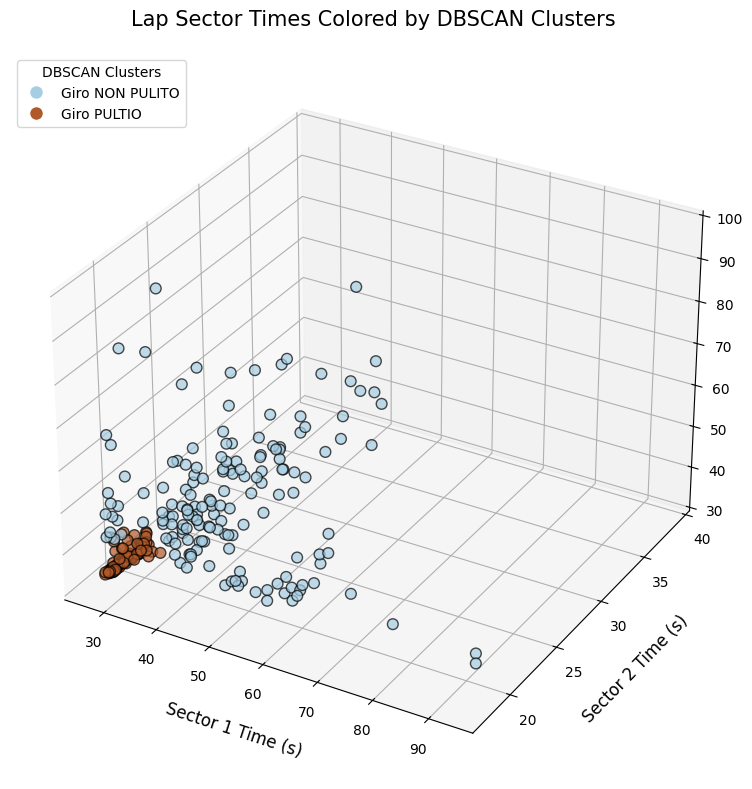

In [95]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assume `laps` has a 'dbscan_cluster' column already added

# Optional: sort cluster labels to keep consistent coloring
unique_clusters = sorted(sectors_clean['dbscan_cluster'].unique())
num_clusters = len(unique_clusters)

# Generate a color map for clusters
colors_map = plt.cm.get_cmap('Paired', num_clusters)  # or 'Set1', 'tab20', etc.

# Map each cluster label to a color
cluster_colors = sectors_clean['dbscan_cluster'].apply(
    lambda x: colors_map(unique_clusters.index(x) / (num_clusters - 1 if num_clusters > 1 else 1))
)

# 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    sectors_clean['Sector1Time'],
    sectors_clean['Sector2Time'],
    sectors_clean['Sector3Time'],
    c=cluster_colors,
    s=60,
    alpha=0.7,
    edgecolor='k'
)

ax.set_xlabel('Sector 1 Time (s)', fontsize=12, labelpad=12)
ax.set_ylabel('Sector 2 Time (s)', fontsize=12, labelpad=12)
ax.set_zlabel('Sector 3 Time (s)', fontsize=12, labelpad=12)
ax.set_title('Lap Sector Times Colored by DBSCAN Clusters', fontsize=15, pad=20)

# Create a custom legend for clusters
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'Giro {label}',
           markerfacecolor=colors_map(i / (num_clusters - 1 if num_clusters > 1 else 1)), markersize=10)
    for i, label in enumerate(unique_clusters)
]
ax.legend(handles=legend_elements, title='DBSCAN Clusters', loc='upper left')

ax.grid(True)
plt.tight_layout()
plt.show()


Siccome anche fastF1 ci forniva una caratterizzazione dei giri "puliti" possiamo verificare se i nostri risultati concordano con i loro. Per noi è importante che tutti i giri puliti risultino effettivamente tali, valutiamo dunque la Positive Predictive Value (precisione).

In [94]:
falsi_positivi = laps[(laps["dbscan_cluster"] == 'PULTIO') & (laps["IsAccurate"] == False)]
true_positivi = laps[(laps["dbscan_cluster"] == 'PULTIO') & (laps["IsAccurate"] == True)]
falsi_negativi = laps[(laps["dbscan_cluster"] == 'NON PULITO') & (laps["IsAccurate"] == True)]
true_negativi = laps[(laps["dbscan_cluster"] == 'NON PULITO') & (laps["IsAccurate"] == False)]

Precision = len(true_positivi) / (len(true_positivi) + len(falsi_positivi))
Accuracy = (len(true_positivi) + len(true_negativi)) / (len(falsi_positivi) + len(true_positivi) + len(falsi_negativi) + len(true_negativi))

print(f"Precisione: {Precision * 100}%")
print(f"Accuratezza: {Accuracy * 100:.2f}%")

Precisione: 100.0%
Accuratezza: 76.65%


Proseguiamo consapevoli che precedentemente i creatori di fastf1 consideravano "Validi" anche giri contenenti errori dei piloti. E che quindi è normale avere risultati più restrittivi in termini di scelta dei giri puliti.

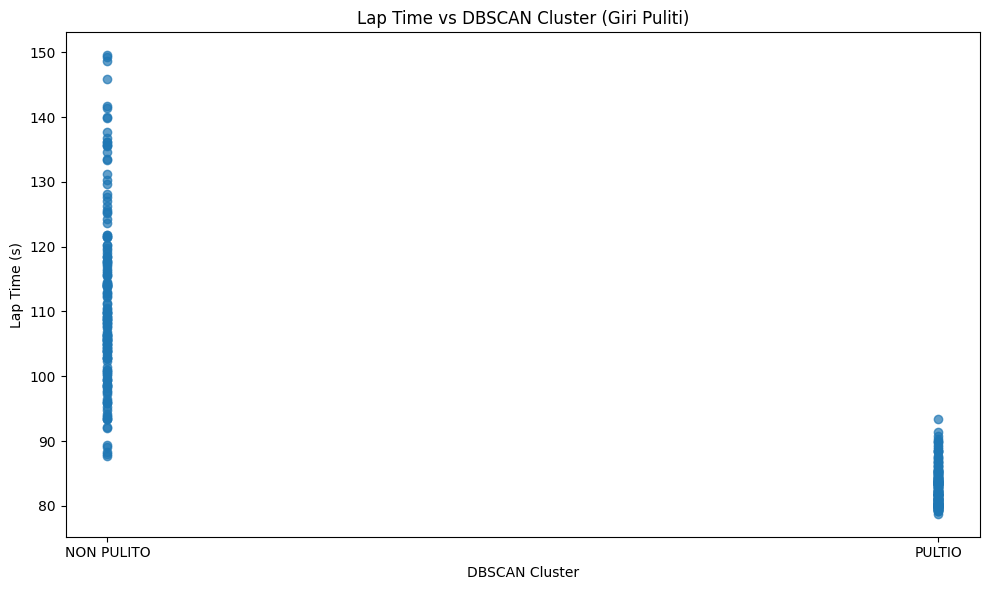

In [114]:
clean_laps = laps[laps['dbscan_cluster'] == 'PULTIO']

import matplotlib.pyplot as plt

# Plot LapTime vs dbscan_cluster with closer x-axis categories
plt.figure(figsize=(10, 6))
plt.scatter(
    laps['dbscan_cluster'].map({'NON PULITO': 0, 'PULTIO': 1}),
    laps['LapTime'],
    alpha=0.7
)
plt.xticks([0, 1], ['NON PULITO', 'PULTIO'])
plt.xlabel('DBSCAN Cluster')
plt.ylabel('Lap Time (s)')
plt.title('Lap Time vs DBSCAN Cluster (Giri Puliti)')
plt.tight_layout()
plt.show()


Proviamo ora una nuova strategia di clustering in cui utilizziamo anche l'usura e il tipo delle gomme.

TyreLife, Compound

Inizialmente dobbiamo trasformare compound in una variabile numerica

In [228]:
laps, weather = get_data_laps(2023, 'Australia', 'FP1')

core           INFO 	Loading data for Australian Grand Prix - Practice 1 [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '2', '4', '10', '11', '14', '16', '18', '20', '21', '22', '23', '24', '27', '31', '44', '55', '63', '77', '81']


In [229]:
SOFT = 0
MEDIUM = 1
HARD = 2

laps['Compound'] = laps['Compound'].map({'SOFT': 0, 'MEDIUM': 1, 'HARD': 2})
laps['TyreLife'] = laps['TyreLife'].astype(int)

# Remove OutLap and InLap from laps
laps = laps[~(laps['OutLap'] | laps['InLap'])]

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import chebyshev, minkowski
import numpy as np

# Prepare the data (use the same columns as before)
cols = ['Sector1Time', 'Sector2Time', 'Sector3Time', 'TyreLife', 'LapsInStint']
sectors_clean = laps[cols].dropna()
X = sectors_clean.values

# Standardize features
X_scaled = StandardScaler().fit_transform(X)

def custom_metric(u, v, alpha=0.5, beta=0.5):
    laptime_diff = chebyshev(u[:3], v[:3]) * alpha
    tyre_age_diff = abs(u[3] - v[3]) * (1 - alpha) * beta
    fuel_diff = abs(u[4] - v[4]) * (1 - alpha) * (1 - beta)
    return laptime_diff + tyre_age_diff + fuel_diff

# Run DBSCAN with the custom metric
dbscan = DBSCAN(eps=0.3, min_samples=5, metric=custom_metric)
labels = dbscan.fit_predict(X_scaled)

# Assign cluster labels using the correct index
laps.loc[sectors_clean.index, 'dbscan_cluster_2'] = labels
print(laps['dbscan_cluster_2'].value_counts())

dbscan_cluster_2
 0.0    219
-1.0     40
Name: count, dtype: int64


C:\Users\marti\AppData\Local\Temp\ipykernel_18032\2378540079.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Paired', n_clusters)


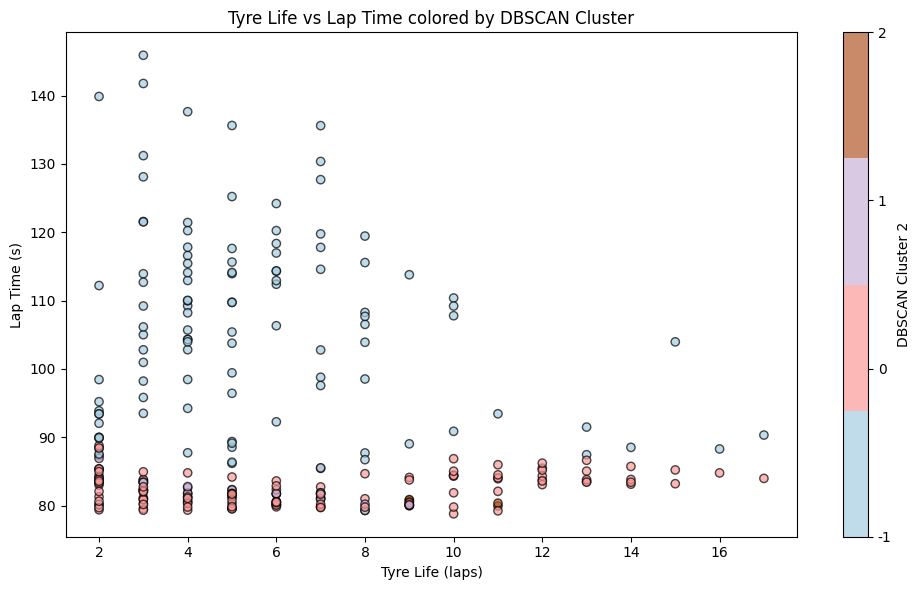

In [251]:
import numpy as np

import matplotlib.pyplot as plt

# Get unique cluster labels (excluding NaN)
cluster_labels = np.sort(laps['dbscan_cluster_2'].dropna().unique())
n_clusters = len(cluster_labels)

# Create a color map with as many colors as clusters
cmap = plt.cm.get_cmap('Paired', n_clusters)

# Map each cluster label to a color index
label_to_color_idx = {label: idx for idx, label in enumerate(cluster_labels)}
colors = laps['dbscan_cluster_2'].map(label_to_color_idx)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    laps['TyreLife'],
    laps['LapTime'],
    c=colors,
    cmap=cmap,
    alpha=0.7,
    edgecolor='k'
)
plt.xlabel('Tyre Life (laps)')
plt.ylabel('Lap Time (s)')
plt.title('Tyre Life vs Lap Time colored by DBSCAN Cluster')
cbar = plt.colorbar(scatter, ticks=range(n_clusters))
cbar.ax.set_yticklabels([str(int(label)) for label in cluster_labels])
cbar.set_label('DBSCAN Cluster 2')
plt.tight_layout()
plt.show()

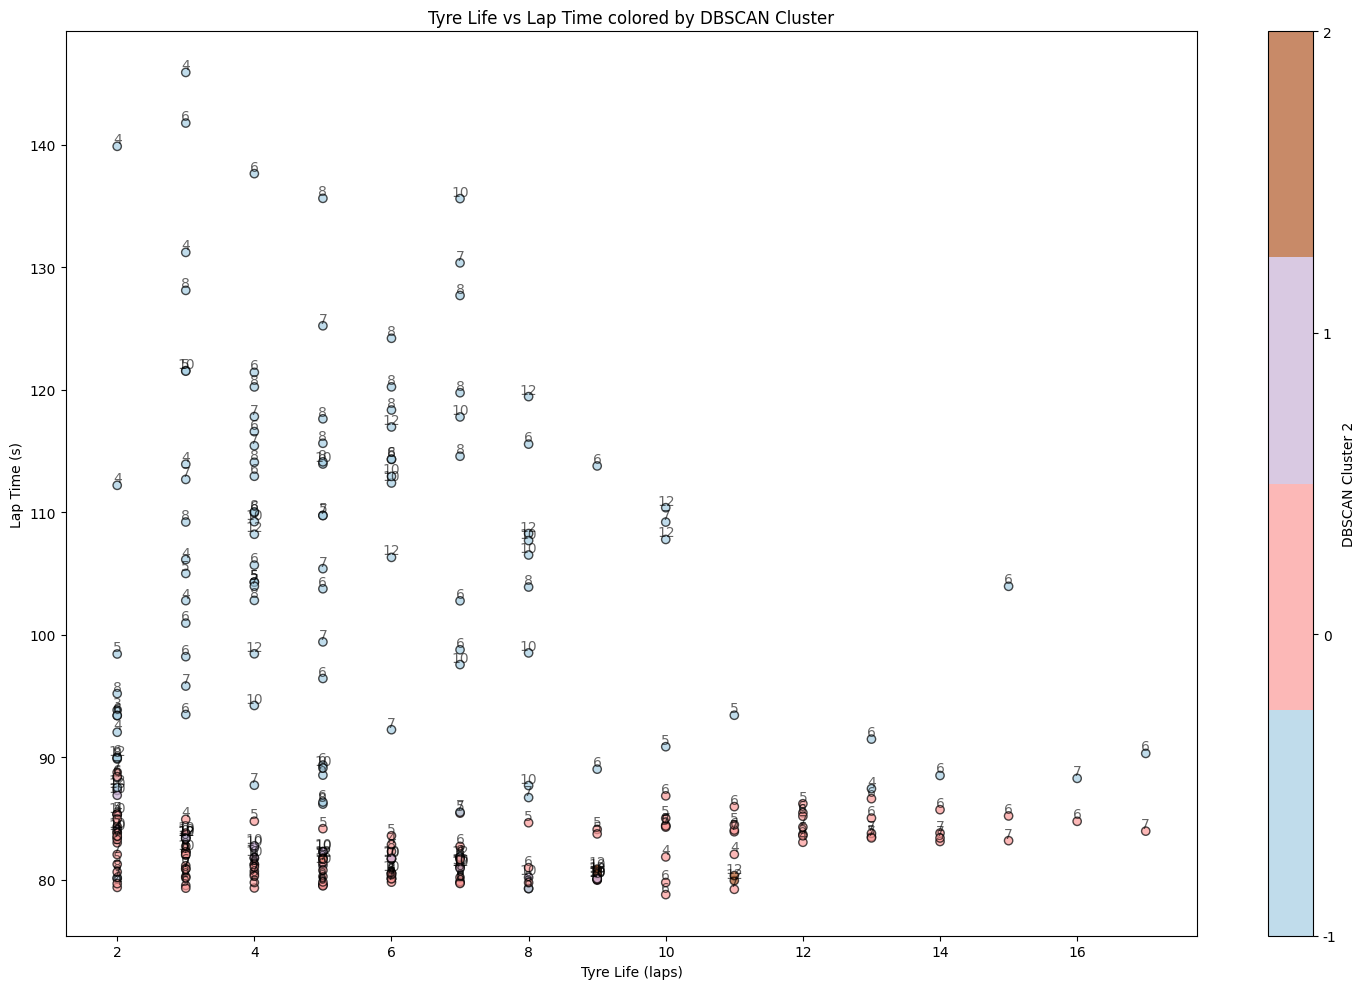

In [250]:
plt.figure(figsize=(15, 10))
scatter = plt.scatter(
    laps['TyreLife'],
    laps['LapTime'],
    c=colors,
    cmap=cmap,
    alpha=0.7,
    edgecolor='k'
)
plt.xlabel('Tyre Life (laps)')
plt.ylabel('Lap Time (s)')
plt.title('Tyre Life vs Lap Time colored by DBSCAN Cluster')

# Add labels for the LapsInStint value
for idx, row in laps.dropna(subset=['LapTime', 'TyreLife', 'LapsInStint']).iterrows():
    plt.text(
        row['TyreLife'],
        row['LapTime'],
        int(row['LapsInStint']),
        fontsize=10,
        ha='center',
        va='bottom',
        alpha=0.6
    )

cbar = plt.colorbar(scatter, ticks=range(n_clusters))
cbar.ax.set_yticklabels([str(int(label)) for label in cluster_labels])
cbar.set_label('DBSCAN Cluster 2')
plt.tight_layout()
plt.show()


##### Giri veloci o simulazioni di passo gara
L'obiettivo è identificare se un giro (appartentente ad un giro veloce) appartenga ad una simulazione di passo gara o ad una simulazione di qualifica.